***About Dataset***

Dataset yang digunakand dalam tugas ini adalah bersumber dari kaggel. Dataset ini merupakan dataset untuk multi label kategory berita BBC, bisa di akses dalam [Tautan](https://www.kaggle.com/datasets/sainijagjit/bbc-dataset) ini.

Data tersebut memiliki 5 label atau kelas (sport, business, politics, tech, dan entertainment). Total data ada 2225 baris dan 2 kolom, kolom label dan judul berita.

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from google.colab import files
import os
import re
import textblob
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

# Download Dataset

In [ ]:
# Upload file kaggle.json for permission download
files.upload()

In [4]:
os.listdir()

['.config', 'kaggle.json', 'sample_data']

In [5]:
# Move file kaggle.jsonn to root folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# set permissions
!chmod 600 /root/.kaggle/kaggle.json
# list all available datasets
# !kaggle datasets list

In [6]:
!kaggle datasets download -d sainijagjit/bbc-dataset

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 195MB/s]


In [7]:
!unzip bbc-dataset.zip

Archive:  bbc-dataset.zip
  inflating: bbc-text.csv            


# Data Load

In [8]:
# Read dataset
read_data = pd.read_csv('bbc-text.csv')

In [9]:
read_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [10]:
read_data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [11]:
read_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


# Data Preprocessing

## Label Preprocessing

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64


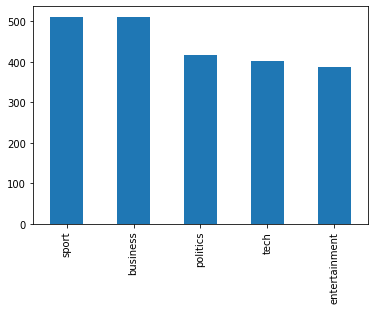

In [12]:
# checking distribution of label
print(read_data['category'].value_counts())

#plot the distirbution
read_data['category'].value_counts().plot.bar()

In [13]:
# Get dummies data
category = pd.get_dummies(read_data.category)
df_baru = pd.concat([read_data, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           2225 non-null   object
 1   business       2225 non-null   uint8 
 2   entertainment  2225 non-null   uint8 
 3   politics       2225 non-null   uint8 
 4   sport          2225 non-null   uint8 
 5   tech           2225 non-null   uint8 
dtypes: object(1), uint8(5)
memory usage: 28.4+ KB


In [14]:
# define label
label_news = df_baru.drop('text', axis=1).values
label_news

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

## Text/Attribute Preprocessing

In [15]:
!wget https://raw.githubusercontent.com/sholied/Dicoding-ProjectAkhir/main/dict.txt

--2022-09-27 03:38:51--  https://raw.githubusercontent.com/sholied/Dicoding-ProjectAkhir/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2933 (2.9K) [text/plain]
Saving to: ‘dict.txt’

dict.txt            100%[===================>]   2.86K  --.-KB/s    in 0s      

2022-09-27 03:38:52 (50.4 MB/s) - ‘dict.txt’ saved [2933/2933]



In [16]:
# define contractions function
def contractions(text):
	# https://gist.github.com/nealrs/96342d8231b75cf4bb82
	# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

	cDict = json.load(open("dict.txt"))
	try:
		c_re = re.compile('(%s)' % '|'.join(cDict.keys()))

		def expandContractions(text, c_re=c_re):
			def replace(match):
				return cDict[match.group(0)]
			return c_re.sub(replace, text)
		
		text = expandContractions(text.lower())
		return text
	except Exception as e:
		print("contractions", e)


In [17]:
# remove stopwrods
stopwords_en = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
  result = []
  for token in text:
      if token not in stopwords_en:
          result.append(token)
  return result

# stemming
def stemming(text):
  porter = nltk.stem.PorterStemmer()
  result=[]
  for word in text:
      result.append(porter.stem(word))
  return result

# lemmatization
def lemmatization(text): 
  result=[]
  wordnet = nltk.stem.WordNetLemmatizer()
  for token,tag in nltk.pos_tag(text):
      pos=tag[0].lower()     
      if pos not in ['a', 'r', 'n', 'v']:
          pos='n'         
      result.append(wordnet.lemmatize(token,pos))
  return result

In [18]:
# make preprocessing text (remove urls, hastags, mention, etc) function
def textPreprocessing(text):
  try:
    # contractions
    text = contractions(text)
    # remove URLs
    text = re.sub('https?://[A-Za-z0-9./?&=_]+','',text)
    # hashtags
    text = re.sub('#[A-Za-z0-9]+','',text)
    # mentions
    text = re.sub('@[A-Za-z0-9._-]+','',text)
    #remove white spaces
    text = " ".join(text.strip().split())
    #lowercasing
    text = text.lower()
  except Exception as e:
    print("clearText error - ", e)

  return text

In [19]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           2225 non-null   object
 1   business       2225 non-null   uint8 
 2   entertainment  2225 non-null   uint8 
 3   politics       2225 non-null   uint8 
 4   sport          2225 non-null   uint8 
 5   tech           2225 non-null   uint8 
dtypes: object(1), uint8(5)
memory usage: 28.4+ KB


In [20]:
# preprocessing text 
df_baru.text=df_baru.text.apply(textPreprocessing)
# tokenization
df_baru.text=df_baru.text.apply(lambda X: nltk.word_tokenize(X))
# Stopwords
df_baru.text=df_baru.text.apply(remove_stopwords)
# lemmatization
df_baru.text=df_baru.text.apply(lemmatization)
# Steamming
df_baru.text=df_baru.text.apply(stemming)

In [21]:
df_baru

,text,business,entertainment,politics,sport,tech
0,"[tv, futur, hand, viewer, home, theatr, system...",0,0,0,0,1
1,"[worldcom, bo, leav, book, alon, former, world...",1,0,0,0,0
2,"[tiger, wari, farrel, gambl, leicest, say, rus...",0,0,0,1,0
3,"[yead, face, newcastl, fa, cup, premiership, s...",0,0,0,1,0
4,"[ocean, twelv, raid, box, offic, ocean, twelv,...",0,1,0,0,0
...,...,...,...,...,...,...
2220,"[car, pull, u, retail, figur, u, retail, sale,...",1,0,0,0,0
2221,"[kilroy, unveil, ammigr, polici, ex-chatshow, ...",0,0,1,0,0
2222,"[rem, announc, new, glasgow, concert, u, band,...",0,1,0,0,0
2223,"[polit, squabbl, snowbal, becom, commonplac, a...",0,0,1,0,0


In [22]:
content = df_baru.text.values

In [23]:
# Tokenizer define
maxlen = 200
tokenizer = Tokenizer(num_words=5000, oov_token='-')
tokenizer.fit_on_texts(content)
sekuens = tokenizer.texts_to_sequences(content)
paddedset = pad_sequences(sekuens, maxlen=maxlen)
vocab_size = len(tokenizer.word_index)+1

In [24]:
paddedset.shape, label_news.shape

((2225, 200), (2225, 5))

In [25]:
# split data into data train, validation (80 : 20)
data_latih, data_test, label_latih, label_test = train_test_split(paddedset, label_news, test_size=0.2, random_state=42)

In [26]:
n, num_class = label_latih.shape

# Model Training

In [27]:
# callback definition
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                              filepath="/content/model.h5",
                                                              monitor='val_loss',
                                                              save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                                                monitor='val_loss', 
                                                factor=0.2, 
                                                mode = 'min',
                                                patience=4, 
                                                min_lr=0.00000001)

#define custom early stopping when reach accuracy above 98%
class myCustomEarlyStopping(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.90):
          print("\n Stop training, the model has reached {}% val accuracy!!".format(logs.get('val_accuracy')*100))   
          self.model.stop_training = True

early_stop = myCustomEarlyStopping()

callbacks = [model_checkpoint_callback, reduce_lr, [early_stop]]

In [28]:
# create model LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=50, input_length=200),
    tf.keras.layers.SpatialDropout1D(0.15),
    tf.keras.layers.LSTM(50, dropout=0.2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_class, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           1241850   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 50)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [29]:
num_epochs = 30
history = model.fit(data_latih, label_latih, epochs=num_epochs, batch_size=10, 
                    validation_data=(data_test, label_test), verbose=1, callbacks = callbacks)

Epoch 1/30
178/178 [==============================] - 10s 15ms/step - loss: 1.4102 - accuracy: 0.3388 - val_loss: 1.1064 - val_accuracy: 0.4517 - lr: 0.0010
Epoch 2/30
178/178 [==============================] - 2s 12ms/step - loss: 0.9406 - accuracy: 0.5685 - val_loss: 0.6097 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 3/30
178/178 [==============================] - 2s 11ms/step - loss: 0.5776 - accuracy: 0.7590 - val_loss: 0.6483 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 4/30
178/178 [==============================] - 2s 12ms/step - loss: 0.2498 - accuracy: 0.9264 - val_loss: 0.4005 - val_accuracy: 0.8697 - lr: 0.0010
Epoch 5/30
178/178 [==============================] - 2s 12ms/step - loss: 0.0960 - accuracy: 0.9742 - val_loss: 0.3755 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 6/30
174/178 [============================>.] - ETA: 0s - loss: 0.1234 - accuracy: 0.9684
 Stop training, the model has reached 90.1123583316803% val accuracy!!
178/178 [==============================] - 2s 11ms/s

# Model Evaluation

In [30]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9933
Testing Accuracy:  0.8854


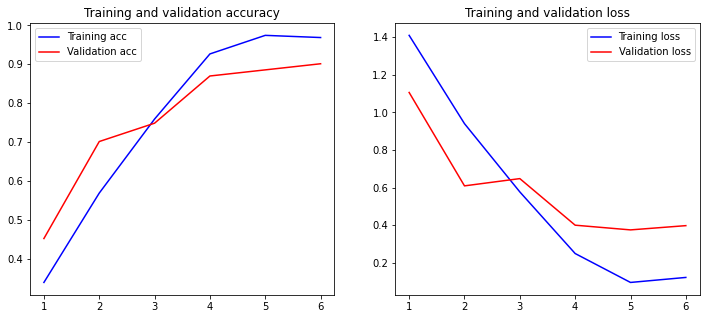

In [32]:
mymodel = tf.keras.models.load_model("/content/model.h5")
loss, accuracy = mymodel.evaluate(data_latih, label_latih, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mymodel.evaluate(data_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)